# Hands-on Exercise — Neural Network Classification with LSS Power Spectra P(k)

In this exercise you will train a neural network to classify two cosmological models
based on **simulated matter power spectra** \(P(k)\).

We will simulate two classes:

- **Class 0**: baseline ΛCDM-like \(P(k)\)
- **Class 1**: modified \(P(k)\) with a feature/suppression/oscillation

Your tasks:

✅ Generate the dataset  
✅ Normalize inputs  
✅ Train a neural network classifier  
✅ Evaluate with learning curves + confusion matrix  
✅ Improve accuracy by changing one element (architecture)

This notebook is designed for a live session: it should run fast on CPU.


In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

rng = np.random.default_rng(0)
tf.random.set_seed(0)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True


## 1. Background (physics)

In large-scale structure, the **matter power spectrum** \(P(k)\) encodes how matter is distributed across scales.

- Large \(k\) = small scales
- Small \(k\) = large scales

Different cosmologies can change the *shape* of \(P(k)\), for example:
- changes in tilt,
- small-scale suppression,
- oscillatory features,
- baryon acoustic oscillation patterns (BAO).

Here we build a toy version of this idea:

We generate vectors \(P(k)\) sampled on a grid of \(k\) values,
then train a neural network to classify the model.


In [7]:
# k grid (log-spaced)
k = np.logspace(-3, 0, 200)  # from 1e-3 to 1

def pk_baseline(k, A=1.0, ns=0.96, k_damp=0.4):
    """
    Toy ΛCDM-like matter power spectrum:
    - power-law tilt with ns
    - exponential small-scale damping
    """
    pk = A * (k ** ns) * np.exp(-(k / k_damp)**2)
    return pk

def pk_feature_model(k, A=1.0, ns=0.96, k_damp=0.4,
                     amp=0.2, k0=0.1, width=0.05, freq=70):
    """
    Toy "feature model": baseline P(k) times a localized oscillatory feature.
    """
    pk0 = pk_baseline(k, A=A, ns=ns, k_damp=k_damp)
    bump = np.exp(-0.5*((k - k0)/width)**2) * np.sin(freq*(k-k0))
    return pk0 * (1.0 + amp*bump)


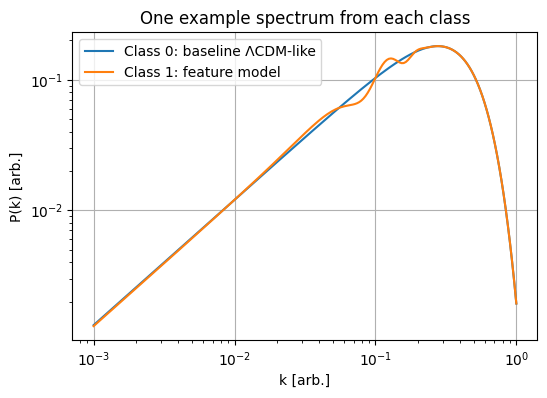

In [8]:
pk0 = pk_baseline(k)
pk1 = pk_feature_model(k)

plt.plot(k, pk0, label="Class 0: baseline ΛCDM-like")
plt.plot(k, pk1, label="Class 1: feature model")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("k [arb.]")
plt.ylabel("P(k) [arb.]")
plt.title("One example spectrum from each class")
plt.legend()
plt.show()


In [9]:
def generate_dataset(N=3000, noise_frac=0.05):
    X, y = [], []
    
    for i in range(N):
        # small baseline parameter variations
        A = rng.uniform(0.9, 1.1)
        ns = rng.uniform(0.92, 1.0)
        k_damp = rng.uniform(0.3, 0.6)

        if rng.random() < 0.5:
            pk = pk_baseline(k, A=A, ns=ns, k_damp=k_damp)
            label = 0
        else:
            amp = rng.uniform(0.15, 0.3)
            k0 = rng.uniform(0.06, 0.18)
            width = rng.uniform(0.02, 0.06)
            freq = rng.uniform(40, 90)

            pk = pk_feature_model(k, A=A, ns=ns, k_damp=k_damp,
                                  amp=amp, k0=k0, width=width, freq=freq)
            label = 1
        
        # multiplicative noise
        pk_obs = pk * (1.0 + rng.normal(0.0, noise_frac, size=pk.size))
        
        # log transform to compress dynamic range
        X.append(np.log(pk_obs + 1e-12))
        y.append(label)
        
    return np.array(X), np.array(y)

X, y = generate_dataset(N=3000, noise_frac=0.05)
print("X shape:", X.shape)
print("Class counts:", np.unique(y, return_counts=True))

X shape: (3000, 200)
Class counts: (array([0, 1]), array([1504, 1496]))


## 2. Exercise Tasks

### ✅ Task 1:
Split the dataset into train and validation sets.

### ✅ Task 2:
Build and train a neural network classifier.


### ✅ Task 3:
Evaluate the learning curves, plot ROC, AUC and the confusion matrix.

### ✅ Task 4:
What happens if you change the batch size?

### ✅ Task 5 (important):
Normalize the inputs using `StandardScaler` and retrain the model, what happens?

### ✅ Task 6:
Use Early stopping for getting to know how many training epochs are enough. Add: `callbacks=[early_stop]` to your `model.fit()` and change the patience. How many epochs are enough? Early stopping can be imported as: 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


### ✅ Task 7:
Play with Optuna. After doing the normalization, run the cell below:
Change the patience, which is the best suggested architecture?

In [ ]:
import optuna

def objective(trial):
    #Hyperparameters to tune
    n1 = trial.suggest_int("n1", 16, 128, step=16)
    n2 = trial.suggest_int("n2", 16, 128, step=16)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    model = Sequential([
        Dense(n1, activation="relu", input_shape=(X_train_s.shape[1],)),
        Dense(n2, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    #Early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )

    history = model.fit(
        X_train_s, y_train,
        validation_data=(X_val_s, y_val),
        epochs=100,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    #Return best validation accuracy achieved during training
    return max(history.history["val_accuracy"])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

print("Best trial:", study.best_trial.params)
print("Best val accuracy:", study.best_value)